In [1]:
SHOULD_USE_DRIVE = True  # change to true if you have the data in your drive
USE_PREEXISTING_MODELS = SHOULD_USE_DRIVE and True  # Take the modals that was calculated and saved to avoid re-training
# The models zip is missing the first model (pix2pix) currently
GET_ALL_IMAGES_FROM_DRIVE = SHOULD_USE_DRIVE and True  # Take all images from the pre-prepared zip to avoid downloading time

MAX_NUM_IMAGES = 2560 * 4  # Use 2 ^ X / 0.8 value  to keep the train, validation and test data in a pow of 2

Ram and GPU details:

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
import os

BASE_DIR = '/content'  # If you running local use '.' and change SHOULD_USE_DRIVE to False

In [5]:
# Adding a caching layer to help with runtimes:
import json
import numpy as np

USE_CACHE = True
CACHE_FILE = f'{BASE_DIR}/cache.json'

def load_cache():
    if USE_CACHE and os.path.exists(CACHE_FILE):
        with open(CACHE_FILE, 'r') as f:
            cache = json.load(f)
    else:
        cache = {}
    return cache

def save_cache(cache):
    # Save the cache
    if USE_CACHE:
        with open(CACHE_FILE, 'w') as f:
            # json.dump(cache, f, cls=NumpyArrayEncoder, indent=4)
            json.dump(cache, f, indent=4)

def clear_cache():
    cache = {}
    save_cache(cache)
    return cache

cache = load_cache()

ID_MAP_KEY = 'id_map'  # If we had an image with mask the is too small, we give it a value of an image with good mask from the unused image ids.
IMAGE_ANNS_KEY = 'annotations'
DOWNLOADED_IMAGES_KEY = 'downloaded_images'

In [6]:
!pip install pycocotools

Get the annotations_trainval2017 from the cocodataset website, and unzip it.

In [7]:
if not os.path.exists(f"{BASE_DIR}/annotations_trainval2017.zip"):
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip -o annotations_trainval2017.zip

--2024-04-06 19:46:03--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.70, 3.5.28.255, 3.5.25.222, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  88.3MB/s    in 2.7s    

2024-04-06 19:46:06 (88.3 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [8]:
valDataType = 'val2017'
trainDataType = 'train2017'

valAnnFile = f'{BASE_DIR}/annotations/instances_{valDataType}.json'
trainAnnFile = f'{BASE_DIR}/annotations/instances_{trainDataType}.json'

STORED_IMAGE_DIR = f'{BASE_DIR}/images'

In [9]:
import time

import matplotlib
import matplotlib.pyplot as plt
import skimage.transform
import skimage.color
import skimage.io as io

from IPython.display import Image, display
from PIL import ImageOps

import tensorflow as tf
from tensorflow.keras import layers
from keras.backend import clear_session

from pycocotools.coco import COCO
%matplotlib inline

In [10]:
# Initilize coco:
coco=COCO(trainAnnFile)

loading annotations into memory...
Done (t=54.07s)
creating index...
index created!


We used the trainAnnFile and not the valAnnFile because it contains more data (60K+ instead of 2K+)
We didnt use all the data due to limited colab resources so we didnt need to utilize them both.

In [11]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
sports indoor outdoor furniture appliance electronic vehicle food accessory kitchen person animal


In [12]:
CATEGORY_IDS = coco.getCatIds(catNms=['person',])
_image_ids = list(set(coco.getImgIds(catIds=CATEGORY_IDS)))  # make sure there are no duplications
UNUSED_IMAGE_IDS = _image_ids[MAX_NUM_IMAGES:]
IMAGE_IDS = _image_ids[:MAX_NUM_IMAGES]
IMAGE_SIZE = (224, 224)
len(IMAGE_IDS)

10240

In [13]:
def download_multiple_images(image_ids: list[int]):
    """Dowload a batch of images
    Download only the images that are not downloaded yet.
    """
    downloaded_images = cache.get(DOWNLOADED_IMAGES_KEY, {})
    non_downloaded_images = [image_id for image_id in image_ids if str(image_id) not in downloaded_images]
    if len(non_downloaded_images) == 0:
        return
    coco.download(tarDir=STORED_IMAGE_DIR, imgIds=non_downloaded_images)
    downloaded_images.update({str(image_id): f'{STORED_IMAGE_DIR}/{image_id:012d}.jpg' for image_id in non_downloaded_images})

def download_image_path(image_id: int, use_url: bool = False):
    """Download a single image
    If the image was already download and its location was stored in the cache,
    skip it and return its location.
    """
    if use_url:
        # This takes long and is not recommended
        return coco.loadImgs(image_id)[0]['coco_url']

    downloaded_images = cache.get(DOWNLOADED_IMAGES_KEY, {})
    if str(image_id) in downloaded_images:
        return downloaded_images[str(image_id)]
    coco.download(tarDir=STORED_IMAGE_DIR, imgIds=[image_id,])
    image_path = f'{STORED_IMAGE_DIR}/{image_id:012d}.jpg'
    downloaded_images[str(image_id)] = image_path
    cache[DOWNLOADED_IMAGES_KEY] = downloaded_images
    return image_path

In [15]:
def get_image_annotations(image_id: int, category_ids: list[int] = CATEGORY_IDS):
    """Return the annotations related to the given image_id. """
    _ann_ids = cache.get(IMAGE_ANNS_KEY, {})
    if str(image_id) in _ann_ids:
        ann_ids = _ann_ids[str(image_id)]
    else:
        ann_ids = coco.getAnnIds(imgIds=image_id, catIds=category_ids)
        _ann_ids[str(image_id)] = ann_ids
        cache[IMAGE_ANNS_KEY] = _ann_ids
    return coco.loadAnns(ann_ids)

In [16]:
MIN_MASK_CAPACITY_PERCENTAGE = 1  # 1%
import cv2
def get_image_and_mask(
    image_id: int,
    category_ids: list[int] = CATEGORY_IDS,
    image_size: tuple[int, int] = IMAGE_SIZE,
    mask_percentage: int = MIN_MASK_CAPACITY_PERCENTAGE
):
    """Return the image and the mask for the given image_id.
    If the mask is too small, raise an error.
    """
    ann = get_image_annotations(image_id, category_ids)
    image_path = download_image_path(image_id)
    image = io.imread(image_path)

    mask = np.zeros((image.shape[0], image.shape[1]))
    for a in ann:
        mask += coco.annToMask(a)
    mask[mask > 1] = 1
    image = image / 255.

    # mask need to be at least <mask_percentage> of the image
    if mask.sum() <= mask.size * mask_percentage / 100:
      raise ValueError(f"Mask need to be at least {mask_percentage} of the image")

    image = tf.image.resize(image, image_size)
    mask = cv2.resize(mask, image_size, interpolation = cv2.INTER_NEAREST)
    return image, mask


In [18]:
# Get Mask might return an error if the mask is too small
# Here we will bring another image from the unused area
unused_image_ids_copy = UNUSED_IMAGE_IDS.copy()
def get_image_and_mask_safe(
    image_id: int,
    category_ids: list[int] = CATEGORY_IDS,
    image_size: tuple[int, int] = IMAGE_SIZE,
    mask_percentage: int = MIN_MASK_CAPACITY_PERCENTAGE,
    data_indeces: list[int] = None,
    data_indeces_index: int = 0
):
    """Return the image and the mask for the given image_id.
    If the mask is too small, get another image from the unused area.
    """
    global unused_image_ids_copy  # allows modifying the outer unused_image_ids_copy variable

    # If the image_id is in the cache, it means that we decided that it was
    # too small and we re-allocated a new picture to replace it
    if image_id in cache.get(ID_MAP_KEY, {}):
        image_id = cache[ID_MAP_KEY][image_id]

    image_ids_with_bad_masks = []
    try:
        image, mask = get_image_and_mask(image_id, category_ids, image_size, mask_percentage)
    except ValueError as e:
        image_ids_with_bad_masks.append(image_id)
        while len(unused_image_ids_copy) > 0 and data_indeces is not None:
            try:
                image_id = unused_image_ids_copy.pop()
                image, mask = get_image_and_mask(image_id, category_ids, image_size, mask_percentage)
                data_indeces[data_indeces_index] = image_id  # Replace the image_id with the new one
                return image, mask
            except ValueError as e:
                image_ids_with_bad_masks.append(image_id)
                continue
        raise e  # If there are no more unused images, raise the error

    # Save all ids that had a small mask and point them to the new image that replaces them:
    for _id in image_ids_with_bad_masks:
        cache[ID_MAP_KEY][_id] = image_id
    return image, mask


In [19]:
# Show progressbar under the cell
# Usage:
# bar = bar = display(progress(0, 100), display_id=True)
# for i in range(100):
#     bar.update(progress(i, 100))
#     time.sleep(0.1)

from IPython.display import HTML, display

def progress(value, max=100):
    """Return an HTML progress bar for the given value and max. """
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [21]:
from enum import Enum


class DataType(Enum):
    TRAIN = 'train'
    TEST = 'test'
    VALIDATION = 'validation'

size = len(IMAGE_IDS)
n_train = int(size * .8)  # 80%
n_valid = int(size * .1)  # 10%
n_test = size - n_train - n_valid  # 10%

indeces = {
    DataType.TRAIN: IMAGE_IDS[:n_train],
    DataType.VALIDATION: IMAGE_IDS[n_train:n_train+n_valid],
    DataType.TEST: IMAGE_IDS[n_train+n_valid:],
}

def data_generator(
    batch_size: int,  # Amount of pictures that will be stored to the RAM each iteration
    data_type: DataType,  # train / test / validation, using pre-stored image-ids
    max_progress: int = None,  # The cap of the progress-bar
    epochs: int = 1,  # Amount of epochs to train the model
    hide_progress_bar: bool = False  # Hide / Show the progress-bar
):
    """Generator that returns a batch of images and masks.
    The generator shows a progress bar under the cell that is used to show the
    progress of the training.
    """
    data_indeces = indeces[data_type]
    num_samples = len(data_indeces)
    progress_end = epochs * (max_progress or num_samples)
    while True: # so we could reuse the generator multiple times
        if not hide_progress_bar:
            bar = display(progress(0, progress_end), display_id=True)
        for current_epoch in range(epochs):
            progress_start = current_epoch * num_samples
            # Show progress on the iteration over all the samples
            for i in range(0, num_samples, batch_size):
                batch_images_indeces = data_indeces[i:i+batch_size]

                batch_images = np.zeros((batch_size, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
                batch_masks = np.zeros((batch_size, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

                for index, image_id in enumerate(batch_images_indeces):
                    current_index = i + index

                    try:
                      image, mask = get_image_and_mask_safe(image_id, data_indeces=data_indeces, data_indeces_index=current_index)
                    except ValueError:
                      continue  # No image found with a mask bigger than the minimum percentage
                    if len(image.shape) == 2:
                        batch_images[index] = skimage.color.gray2rgb(image)
                    else:
                        batch_images[index] = image
                    batch_masks[index, :, :, 0] = mask

                    # show progress
                    if not hide_progress_bar:
                        bar.update(progress(progress_start + current_index + 1, progress_end))
                yield batch_images, batch_masks

## Mount the drive:
Mounting the drive helps with the following:
 - Allows to download the pre-downloaded images to reduce cpu cost and running time.
 - Allows to download the pre-trained models in case we dont want to train them again
 - Allows to save the results while training the models.

Those options are configured in the beginning of the file as a global feature flag.

In [25]:
drive_location = f'{BASE_DIR}/gdrive'
MY_DRIVE = f'{drive_location}/MyDrive'
zip_drive_location = f'{MY_DRIVE}/train-images.zip'

if SHOULD_USE_DRIVE and not os.path.exists(drive_location):
    from google.colab import drive
    drive.mount('/content/gdrive')
    print("Successfully mounted drive")
elif not SHOULD_USE_DRIVE:
    print("Skipping mount of drive")
else:
    print("Drive is already mounted")

Drive is already mounted


Download all the images from the drive (all 64K images from coco that were downloaded)

In [ ]:
zip_drive_location = f'{MY_DRIVE}/train-images.zip'
new_zip_location = f'{BASE_DIR}/train-images.zip'
if GET_ALL_IMAGES_FROM_DRIVE and os.path.exists(zip_drive_location) and not os.path.exists(new_zip_location):
    # this should take around 10 minutes:
    !cp {zip_drive_location} {new_zip_location}
    !unzip -o {new_zip_location} -d {BASE_DIR}  # After unziping, an 'images' directory will get created inside of /content
    print("Successfully extracted images")
elif not GET_ALL_IMAGES_FROM_DRIVE:
    print("Skipping extraction of images")
else:
    print("Images already extracted")

Skipping extraction of images


Download saved pre trained models from the drive:

In [ ]:
zip_drive_location = f'{MY_DRIVE}/models.zip'
new_zip_location = f'{BASE_DIR}/models.zip'
if USE_PREEXISTING_MODELS and os.path.exists(zip_drive_location) and not os.path.exists(new_zip_location):
    !cp {zip_drive_location} {new_zip_location}
    !unzip -o {new_zip_location} -d {BASE_DIR}  # After unziping all the models will get directly into the /content directory
    print("Successfully extracted models")
elif not USE_PREEXISTING_MODELS:
    print("Skipping extraction of models")
else:
    print("Models already extracted")

Skipping extraction of models


Add all image ids and location to the cache so we wont try to download them again later:

In [ ]:
import pathlib

# Save all images to cache to reduce checking if their are already in the FileSystem lateer:
if os.path.exists(STORED_IMAGE_DIR):
    cache[DOWNLOADED_IMAGES_KEY] = {}
    for file in pathlib.Path(STORED_IMAGE_DIR).iterdir():
        image_id = int(file.stem)
        cache[DOWNLOADED_IMAGES_KEY][str(image_id)] = str(file)

In [ ]:
EXAMPLE_FILE_PATH = f'{BASE_DIR}/examples.png'

def show_images_and_masks(images, masks, amount_per_row: int = 6):
    """Show a batch of images and masks side by side. """
    num_rows = (len(images) + amount_per_row - 1) // amount_per_row

    fig, axes = plt.subplots(num_rows, 2 * amount_per_row, figsize=(24, 24))

    for index, (image, mask) in enumerate(zip(images, masks)):
        row = index // amount_per_row
        col = (index % amount_per_row) * 2

        # Plot image
        axes[row, col].imshow(image)
        axes[row, col].axis('off')

        # Plot mask
        # axes[row, col + 1].imshow(image, interpolation='nearest', vmin=0, vmax=1)
        axes[row, col + 1].imshow(mask.squeeze() > .5, cmap='gray', alpha=.8)
        axes[row, col + 1].axis('off')

    # Hide any extra empty subplots
    for ax in axes.flat[len(images) * 2 * amount_per_row:]:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(EXAMPLE_FILE_PATH)

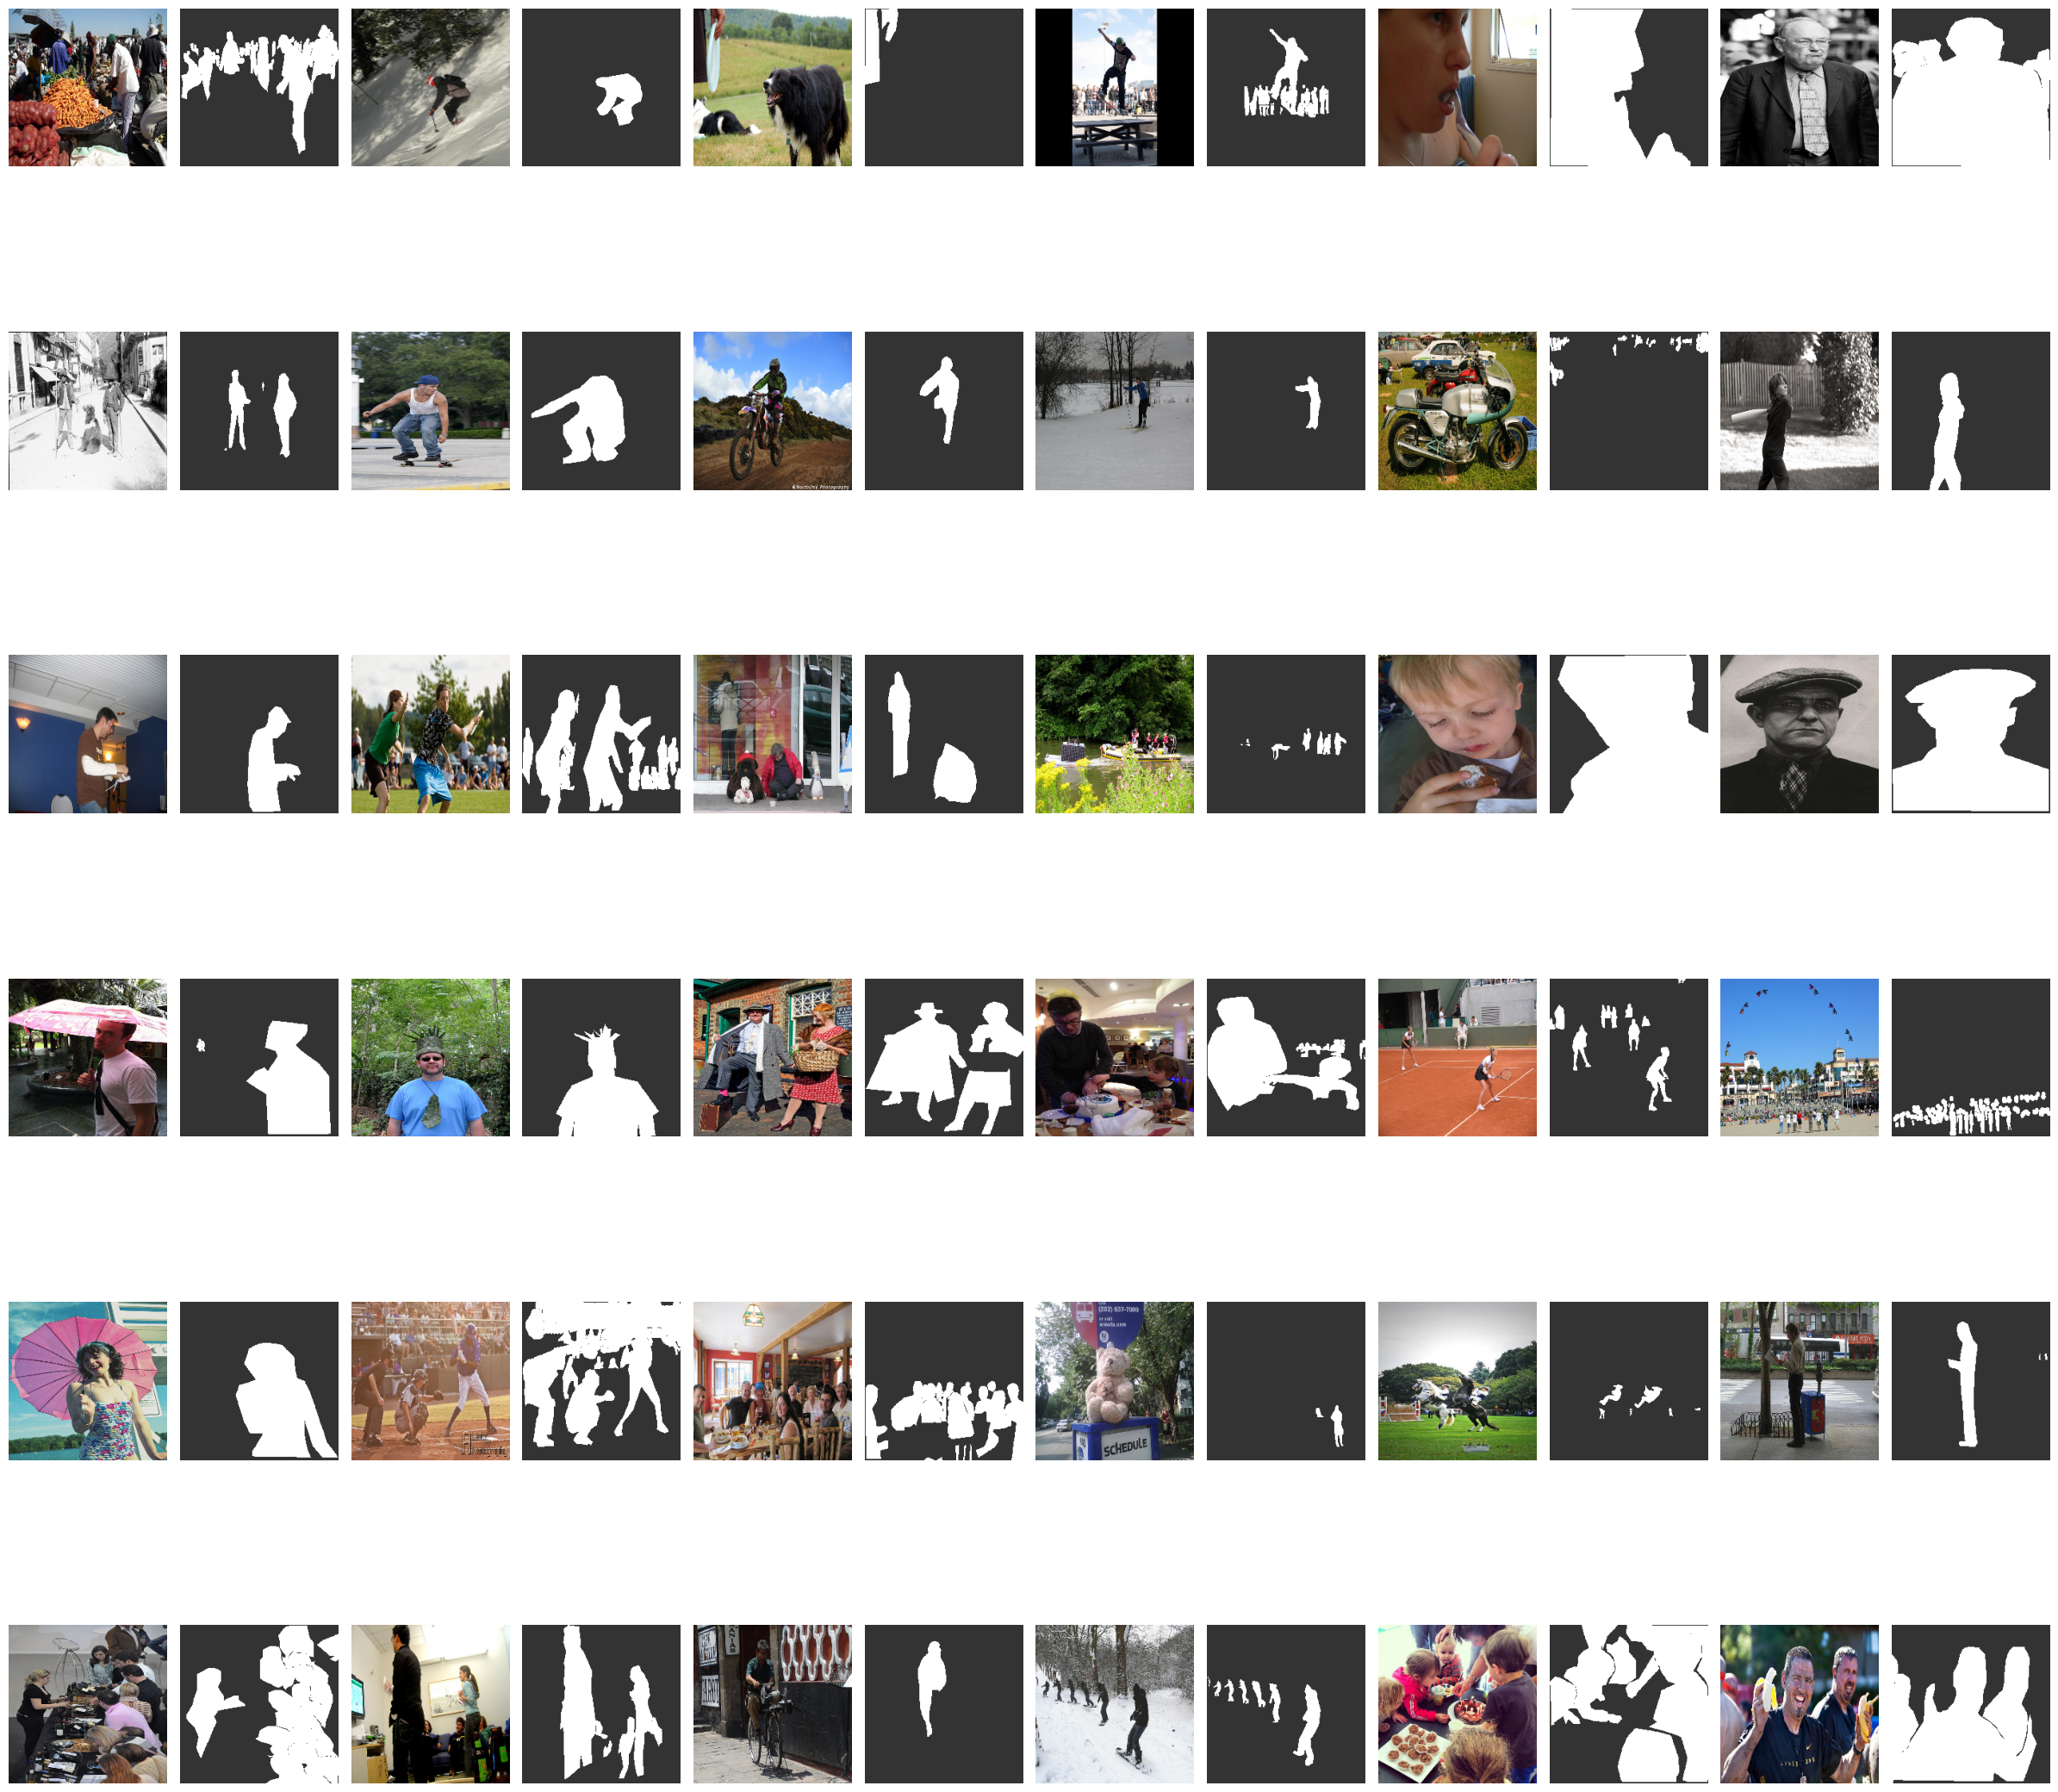

In [ ]:
# Create a png file called examples.png that shows a batch of 36 pictures and masks side by side
temp_generator = data_generator(batch_size=36, data_type=DataType.TRAIN, max_progress=36)
images, masks = next(temp_generator)
show_images_and_masks(images, masks)

In [ ]:
NUM_CLASSES = 3

In [ ]:
batch_size = 128
num_epochs = 16 # Used to be 8, trying 16 for better IOU
train_generator = data_generator(batch_size=batch_size, data_type=DataType.TRAIN, epochs=num_epochs)

Wrapper that clears the ram before each training, and calculate and show how much time the model took to run:

In [ ]:
def fit_model_wrapper(func):  # Gets a fit function
    def wrapper(*args, **kwargs):
        # Free up RAM in case the model definition cells were run multiple times
        clear_session()
        start = time.time()
        result = func(*args, **kwargs)
        print(f"The model took {int(time.time() - start) // 60} minutes")
        return result
    return wrapper

In [ ]:
import math
steps_per_epoch = math.ceil(len(indeces[DataType.TRAIN]) / batch_size)
print(f"Samples: {n_train}, Steps per epoch: {steps_per_epoch}, Batch size: {batch_size}, Num epochs: {num_epochs}")

Samples: 2048, Steps per epoch: 16, Batch size: 128, Num epochs: 16


In [ ]:
steps = math.ceil(len(indeces[DataType.VALIDATION]) / batch_size)
print(f"Samples: {n_valid} Steps: {steps}, Batch size: {batch_size}")

Samples: 256 Steps: 2, Batch size: 128


In [ ]:
import keras.backend as K
from keras.utils import register_keras_serializable

# Since tf's Mean IOU expects a single image, and our network returns
# 'n_classes' probability matrices, we'll use this class that inherits from
# the original metric and adjust the input, using argmax to get the final
# predicted class for each pixel.

@register_keras_serializable()
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true, tf.argmax(y_pred, axis=-1), sample_weight)

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [ ]:
new_model_files = []  # Add each model file

# Pix2Pix U-Net

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE + (3,), include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers_ = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers_)

down_stack.trainable = False

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def get_unet_model(output_channels: int = NUM_CLASSES):
  inputs = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,))

  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  y = last(x)

  return tf.keras.Model(inputs=inputs, outputs=y)

unet_model = get_unet_model()
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 112, 112, 96),       1841984   ['input_2[0][0]']             
                              (None, 56, 56, 144),                                                
                              (None, 28, 28, 192),                                                
                              (None, 14, 14, 576),                                                
                              (None, 7, 7, 320)]                                                  
                                                                                            

In [ ]:
# Download the images so the training will be faster
# Downloading will not run if the images were extracted from the pre-downloaded images zip.
download_multiple_images(indeces[DataType.TRAIN])

In [ ]:
train_generator = data_generator(batch_size=batch_size, data_type=DataType.TRAIN, epochs=num_epochs)
validation_generator = data_generator(batch_size=batch_size, data_type=DataType.VALIDATION, epochs=num_epochs, hide_progress_bar=True)

In [ ]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', MyMeanIOU(num_classes=NUM_CLASSES)]
)

model_file = f"{BASE_DIR}/unet_model.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
]
if not os.path.exists(model_file) or not USE_PREEXISTING_MODELS:
    unet_model_fit = fit_model_wrapper(unet_model.fit)
    unet_model_fit(train_generator, validation_data=validation_generator, validation_steps=steps, steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=callbacks)
    if os.path.exists(drive_location):
        !cp {model_file} {MY_DRIVE}
    new_model_files.append(model_file)
else:
    unet_model.load_weights(model_file)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
# Download the images so the validation will be faster
# Downloading will not run if the images were extracted from the pre-downloaded images zip.
download_multiple_images(indeces[DataType.VALIDATION])

In [ ]:
# Download the images so the test will be faster
# Downloading will not run if the images were extracted from the pre-downloaded images zip.
download_multiple_images(indeces[DataType.TEST])

In [ ]:
test_generator = data_generator(batch_size=n_test, data_type=DataType.TEST)
X_test, y_test = next(test_generator)

def predict_model(model):
    """Predict the masks for the test images.
    Show the images and the masks.
    """
    test_pred = model.predict(X_test)

    for i in range(3):
        fig, axes = plt.subplots(1, 3, figsize=(15, 15))
        axes[0].imshow(X_test[i])
        axes[0].set_title('Image')
        axes[0].axis('off')

        axes[1].imshow(y_test[i].squeeze())
        axes[1].set_title('True Mask')
        axes[1].axis('off')

        axes[2].imshow(test_pred[i].argmax(axis=-1))
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

    plt.show()

    return test_pred

8/8 [==============================] - 40s 5s/step


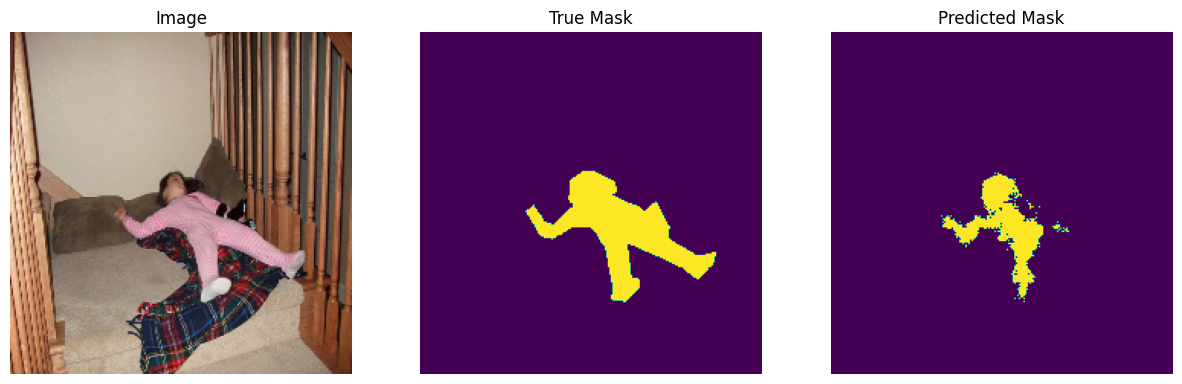

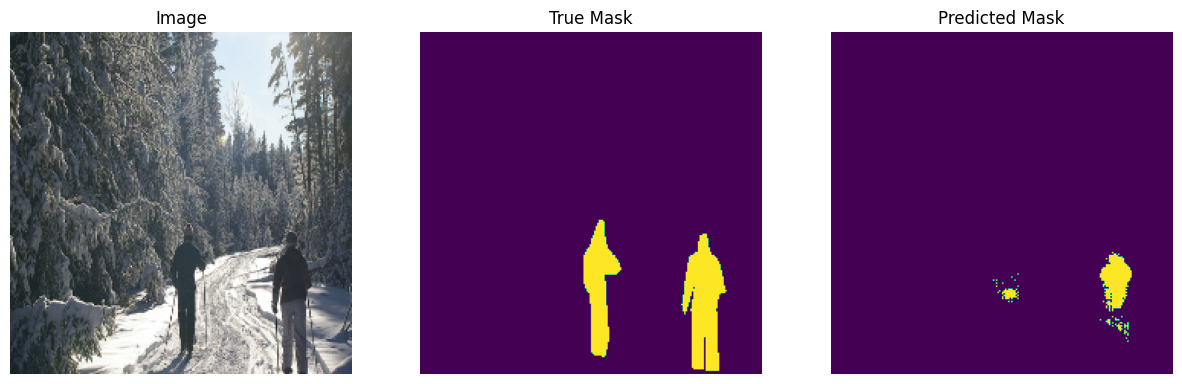

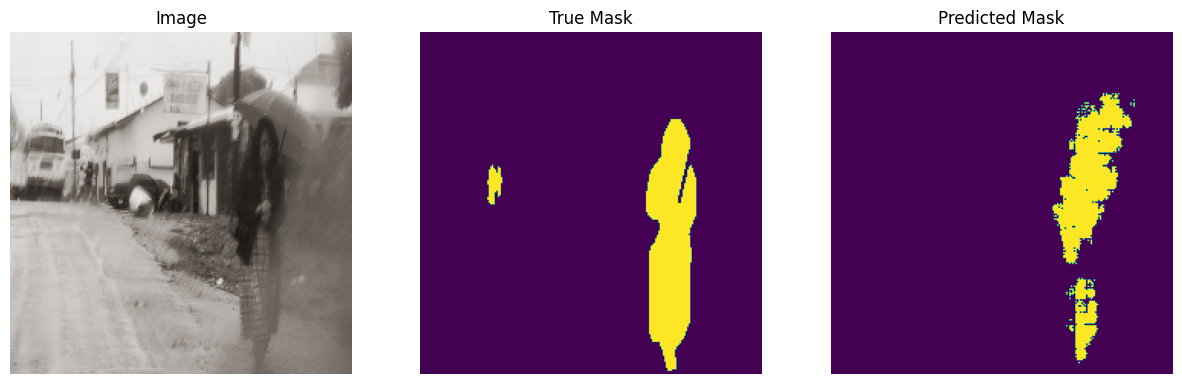

In [ ]:
pred_unet_model = predict_model(unet_model)

In [ ]:
save_cache(cache)

# Transposed convolutions unet model

In [ ]:
def get_transposed_convolutions_unet_model(img_size: tuple[int, int] = IMAGE_SIZE, num_classes: int = NUM_CLASSES):
    inputs = layers.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model

# Build model
model = get_transposed_convolutions_unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 32)         0         ['batch_normalization[0][0

In [ ]:
train_generator = data_generator(batch_size=batch_size, data_type=DataType.TRAIN, epochs=num_epochs)
validation_generator = data_generator(batch_size=batch_size, data_type=DataType.VALIDATION, epochs=num_epochs, hide_progress_bar=True)

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', MyMeanIOU(num_classes=NUM_CLASSES)]
)

model_file = f"{BASE_DIR}/model.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model, doing validation at the end of each epoch.
if not os.path.exists(model_file) or not USE_PREEXISTING_MODELS:
    model_fit = fit_model_wrapper(model.fit)
    model_fit(train_generator, validation_data=validation_generator, validation_steps=steps, steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=callbacks)
    if os.path.exists(drive_location):
        !cp {model_file} {MY_DRIVE}
    new_model_files.append(model_file)
else:
    model.load_weights(model_file)

8/8 [==============================] - 59s 7s/step


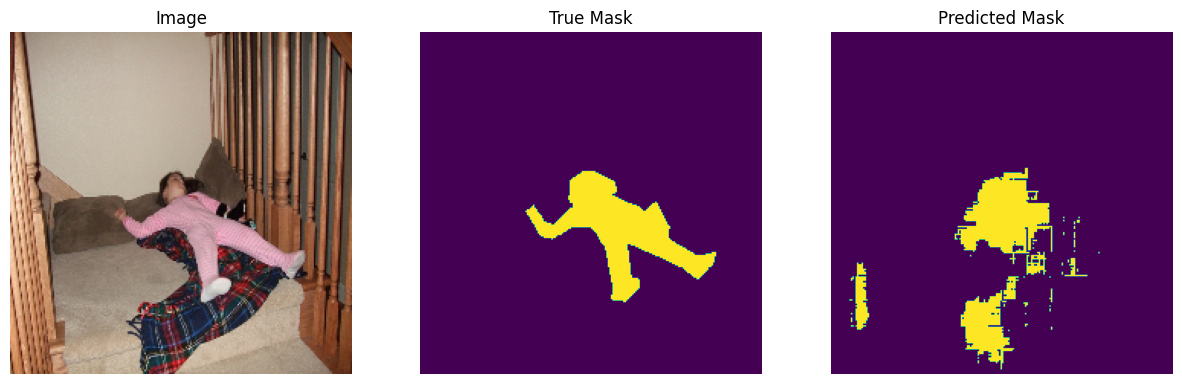

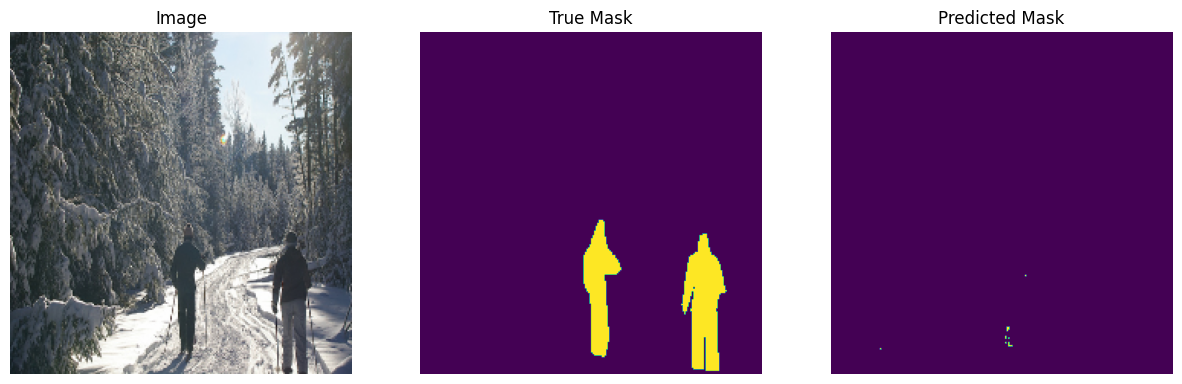

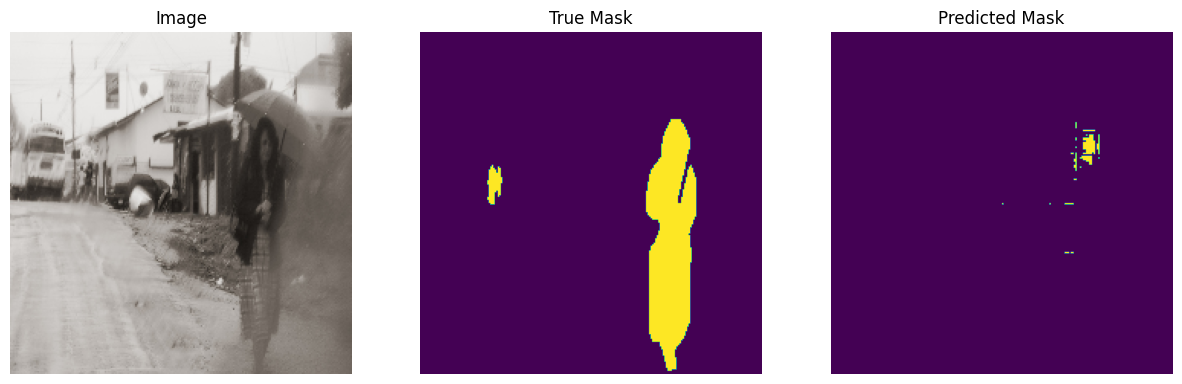

In [ ]:
pred_model = predict_model(model)

# Transfer learning

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=IMAGE_SIZE + (3,), include_top=False)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
sub_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=[base_model.get_layer('conv3_block1_out').output])
sub_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
inputs = layers.Input(shape=IMAGE_SIZE + (3,))
resnet_output = sub_model(inputs)
# If using a stored model use this instead of the one above:
# resnet_output = sub_model(inputs)[0]
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(resnet_output)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
outputs = layers.Conv2D(NUM_CLASSES, 3, activation="softmax", padding="same")(x)

resnet_model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
resnet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 28, 28, 512)       612992    
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 256)       1179904   
                                                                 
 up_sampling2d_8 (UpSamplin  (None, 56, 56, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 128)       295040    
                                                                 
 up_sampling2d_9 (UpSamplin  (None, 112, 112, 128)     0         
 g2D)                                                      

In [ ]:
train_generator = data_generator(batch_size=batch_size, data_type=DataType.TRAIN, epochs=num_epochs)
validation_generator = data_generator(batch_size=batch_size, data_type=DataType.VALIDATION, epochs=num_epochs, hide_progress_bar=True)

In [ ]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', MyMeanIOU(num_classes=NUM_CLASSES)]
)

model_file = f"{BASE_DIR}/resnet_model.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model, doing validation at the end of each epoch.
if not os.path.exists(model_file) or not USE_PREEXISTING_MODELS:
    resnet_model_fit = fit_model_wrapper(resnet_model.fit)
    resnet_model_fit(train_generator, validation_data=validation_generator, validation_steps=steps, epochs=num_epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)
    if os.path.exists(drive_location):
        !cp {model_file} {MY_DRIVE}
    new_model_files.append(model_file)
else:
    resnet_model.load_weights(model_file)

8/8 [==============================] - 61s 8s/step


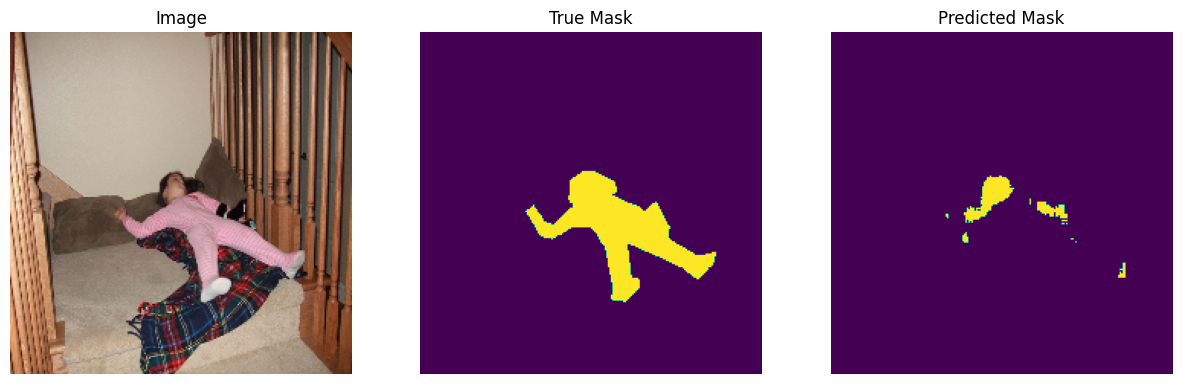

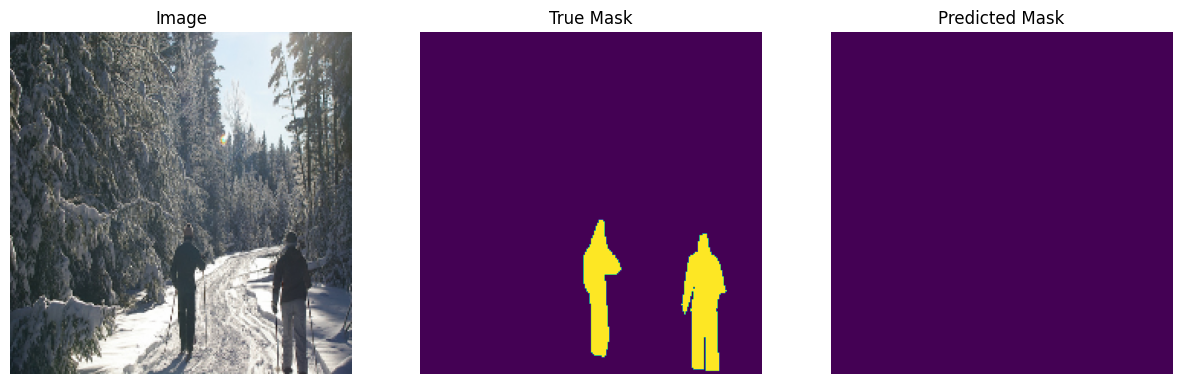

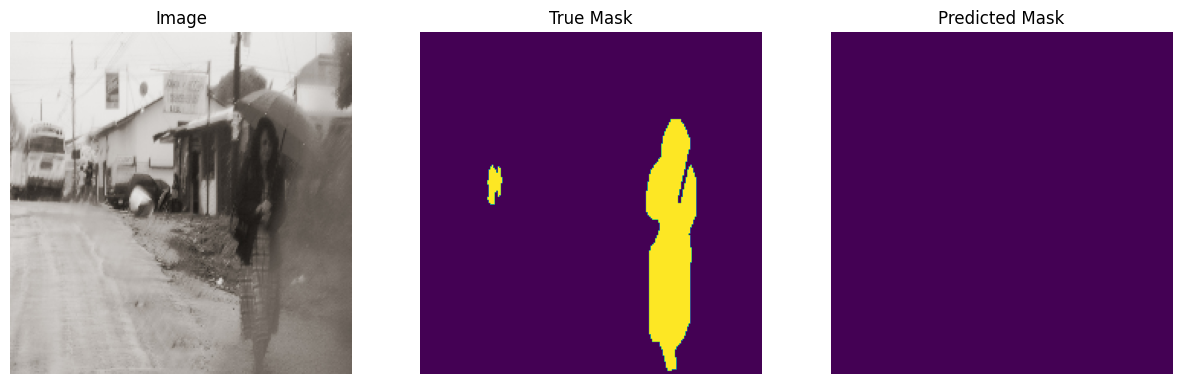

In [ ]:
pred_resnet_model = predict_model(resnet_model)

# Use the weights as-is

In [ ]:
sub_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=[base_model.get_layer('conv3_block1_out').output])
sub_model.trainable = False
sub_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
inputs = layers.Input(shape=IMAGE_SIZE + (3,))
resnet_output = sub_model(inputs)
# If using a stored model use this instead of the one above:
# resnet_output = sub_model(inputs)[0]
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(resnet_output)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
outputs = layers.Conv2D(NUM_CLASSES, 3, activation="softmax", padding="same")(x)

resnet_model2 = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
resnet_model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_3 (Functional)        (None, 28, 28, 512)       612992    
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 256)       1179904   
                                                                 
 up_sampling2d_11 (UpSampli  (None, 56, 56, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 56, 128)       295040    
                                                                 
 up_sampling2d_12 (UpSampli  (None, 112, 112, 128)     0         
 ng2D)                                                     

In [ ]:
train_generator = data_generator(batch_size=batch_size, data_type=DataType.TRAIN, epochs=num_epochs)
validation_generator = data_generator(batch_size=batch_size, data_type=DataType.VALIDATION, epochs=num_epochs, hide_progress_bar=True)

In [ ]:
resnet_model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', MyMeanIOU(num_classes=NUM_CLASSES)]
)

model_file = f"{BASE_DIR}/resnet_model2.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model, doing validation at the end of each epoch.
if not os.path.exists(model_file) or not USE_PREEXISTING_MODELS:
    resnet_model2_fit = fit_model_wrapper(resnet_model2.fit)
    resnet_model2_fit(train_generator, validation_data=validation_generator, validation_steps=steps, steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=callbacks, batch_size=batch_size)
    if os.path.exists(drive_location):
        !cp {model_file} {MY_DRIVE}
    new_model_files.append(model_file)
else:
    resnet_model2.load_weights(model_file)

8/8 [==============================] - 58s 7s/step


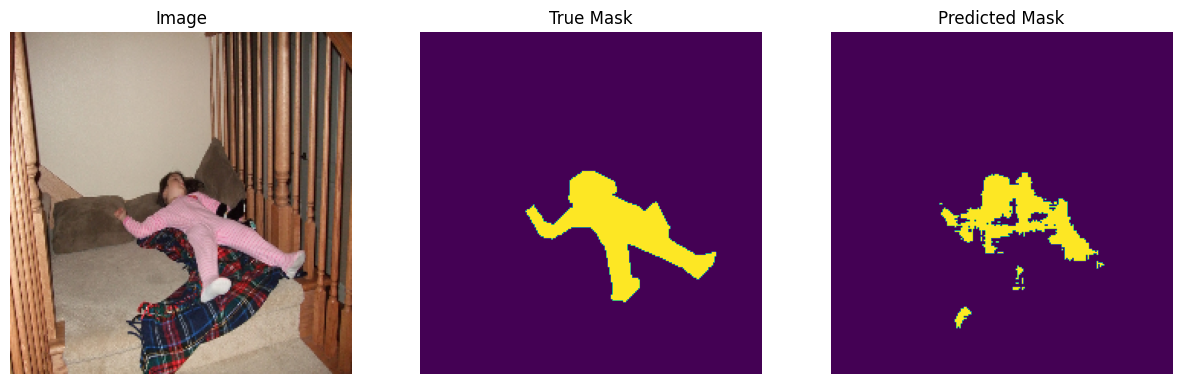

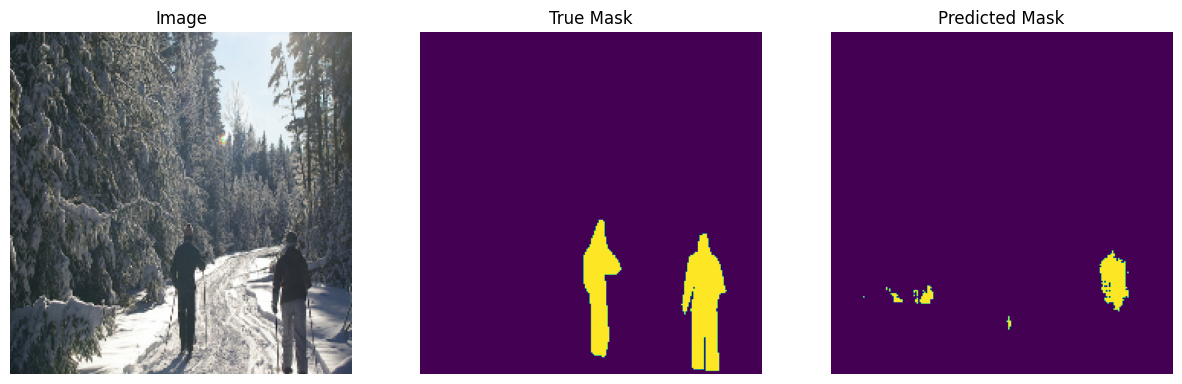

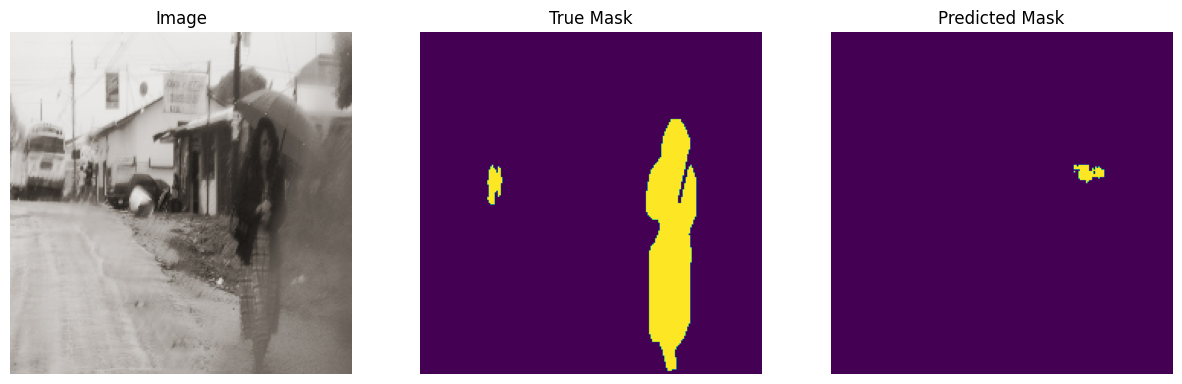

In [ ]:
pred_resnet_model2 = predict_model(resnet_model2)

# VGG19

In [ ]:
base_model = tf.keras.applications.VGG19(input_shape=IMAGE_SIZE + (3,), include_top=False)
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
sub_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=[base_model.get_layer('block4_conv4').output])
sub_model.trainable = False
sub_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
inputs = layers.Input(shape=IMAGE_SIZE + (3,))

vgg_output = sub_model(inputs)
# If using a stored model use this instead of the one above:
# vgg_output = sub_model(inputs)[0]

x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(vgg_output)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
outputs = layers.Conv2D(NUM_CLASSES, 3, activation="softmax", padding="same")(x)

vgg_model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
vgg_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_5 (Functional)        (None, 28, 28, 512)       10585152  
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 256)       1179904   
                                                                 
 up_sampling2d_14 (UpSampli  (None, 56, 56, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 56, 56, 128)       295040    
                                                                 
 up_sampling2d_15 (UpSampli  (None, 112, 112, 128)     0         
 ng2D)                                                     

In [ ]:
train_generator = data_generator(batch_size=batch_size, data_type=DataType.TRAIN, epochs=num_epochs)
validation_generator = data_generator(batch_size=batch_size, data_type=DataType.VALIDATION, epochs=num_epochs, hide_progress_bar=True)

In [ ]:
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', MyMeanIOU(num_classes=NUM_CLASSES)]
)

model_file = f"{BASE_DIR}/vgg_model.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model, doing validation at the end of each epoch.
if not os.path.exists(model_file) or not USE_PREEXISTING_MODELS:
    vgg_model_fit = fit_model_wrapper(vgg_model.fit)
    vgg_model_fit(train_generator, validation_data=validation_generator, validation_steps=steps, steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=callbacks, batch_size=batch_size)
    if os.path.exists(drive_location):
        !cp {model_file} {MY_DRIVE}
    new_model_files.append(model_file)
else:
    vgg_model.load_weights(model_file)

8/8 [==============================] - 225s 28s/step


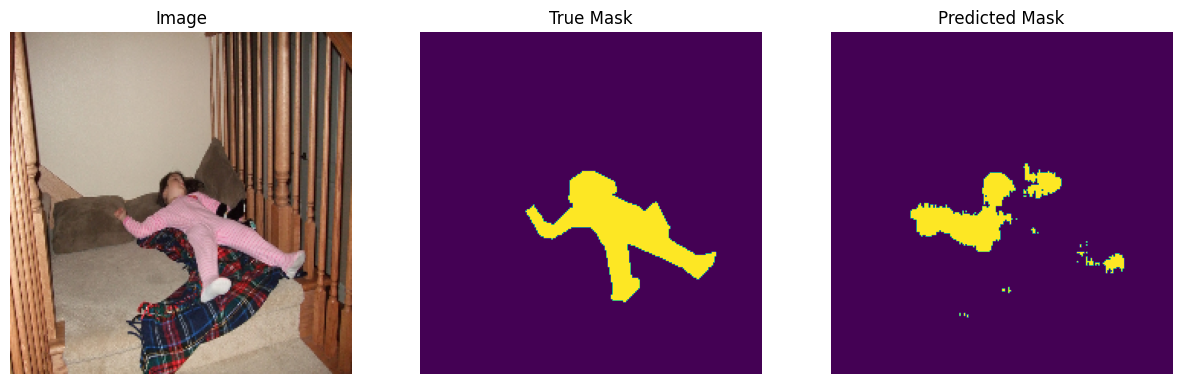

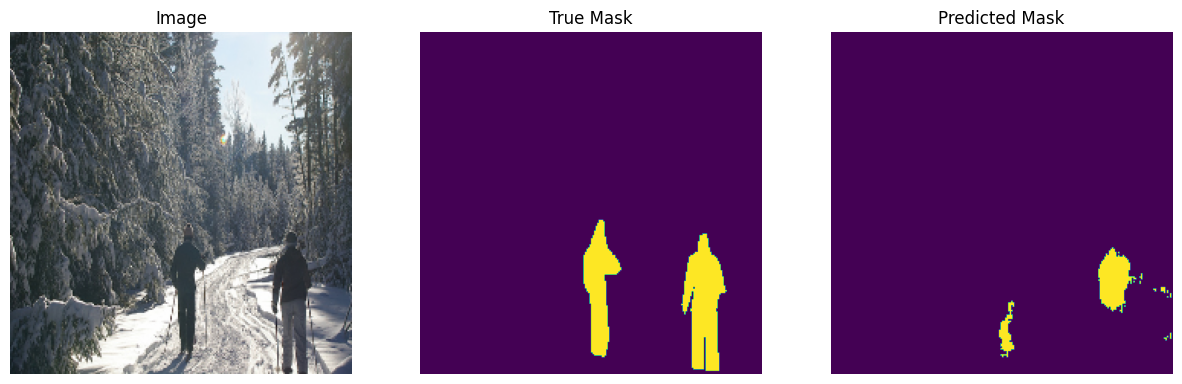

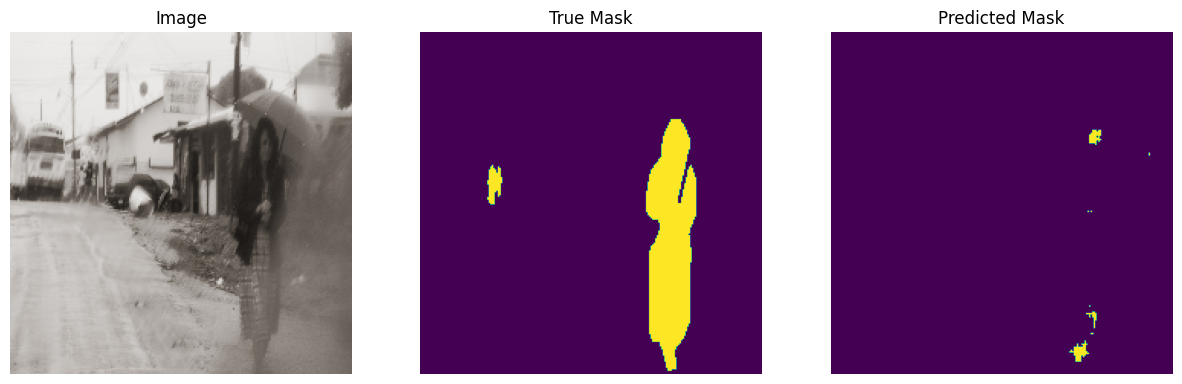

In [ ]:
pred_vgg_model = predict_model(vgg_model)

## Zip and save all models to drive:
Save the models that were trained and saved to a file, to the drive.
This precautionary measure ensured that in the event of a session timeout or data clearance, we retained the valuable model weights.


In [ ]:
new_models_regex = f'{BASE_DIR}/*.keras'
zip_file = f'{BASE_DIR}/models.zip'
drive_location = f'{MY_DRIVE}/models.zip'

!zip -r {zip_file} {new_models_regex}
if os.path.exists(MY_DRIVE) and not os.path.exists(drive_location):
  # Save to drive:
  !cp {zip_file} {drive_location}
  print(f'Saved to {drive_location}')


updating: content/model.keras (deflated 9%)
updating: content/resnet_model2.keras (deflated 7%)
updating: content/resnet_model.keras (deflated 8%)
updating: content/unet_model.keras (deflated 8%)
updating: content/vgg_model.keras (deflated 7%)


# Evaluation

In [ ]:
def calculate_mean_iou(_model, model_name):
    """Calculate each model's mean IOU.
    Print the accuricy, loss, and mean IOU.
    """
    test_loss, test_accuracy, test_mean_iou = _model.evaluate(X_test, y_test)

    print(f"Test accuracy: {test_accuracy} for {model_name}")
    print(f"Test mean IOU: {test_mean_iou} for {model_name}")
    print(f"Test loss: {test_loss} for {model_name}")

    return test_mean_iou

In [ ]:
mean_iou_dict = {}

mean_iou_dict['Original model'] = calculate_mean_iou(model, 'Original model')
mean_iou_dict['ResNet'] = calculate_mean_iou(resnet_model, 'ResNet')
mean_iou_dict['ResNet2'] = calculate_mean_iou(resnet_model2, 'ResNet2')
mean_iou_dict['VGG'] = calculate_mean_iou(vgg_model, 'VGG')
mean_iou_dict['Unet'] = calculate_mean_iou(unet_model, 'Unet')

8/8 [==============================] - 61s 8s/step - loss: 0.3175 - accuracy: 0.9157 - my_mean_iou: 0.5708
Test accuracy: 0.9157257676124573 for Original model
Test mean IOU: 0.5707500576972961 for Original model
Test loss: 0.3175303637981415 for Original model
8/8 [==============================] - 63s 8s/step - loss: 0.2837 - accuracy: 0.8810 - my_mean_iou_1: 0.6365
Test accuracy: 0.8809775710105896 for ResNet
Test mean IOU: 0.6365037560462952 for ResNet
Test loss: 0.2837280035018921 for ResNet
8/8 [==============================] - 60s 8s/step - loss: 0.2269 - accuracy: 0.9003 - my_mean_iou_2: 0.7084
Test accuracy: 0.9002929329872131 for ResNet2
Test mean IOU: 0.7083528637886047 for ResNet2
Test loss: 0.22691498696804047 for ResNet2
8/8 [==============================] - 221s 28s/step - loss: 0.2601 - accuracy: 0.8820 - my_mean_iou_3: 0.6607
Test accuracy: 0.8819587826728821 for VGG
Test mean IOU: 0.6607471108436584 for VGG
Test loss: 0.26013511419296265 for VGG
8/8 [===============

In [ ]:
pred_model_class = tf.argmax(pred_model, axis=-1).numpy()
pred_resnet_model_class = tf.argmax(pred_resnet_model, axis=-1).numpy()
pred_resnet_model_class2 = tf.argmax(pred_resnet_model2, axis=-1).numpy()
pred_unet_model_class = tf.argmax(pred_unet_model, axis=-1).numpy()
pred_vgg_model_class = tf.argmax(pred_vgg_model, axis=-1).numpy()

Based on the results, the Unet (pix2pix) model demonstrated the highest accuracy (0.9406) and mean IOU (0.8168) while showing the lowest loss (0.1480), thus being selected as the optimal model.


In [ ]:
best_model = unet_model
best_pred = pred_unet_model
best_pred_class = pred_unet_model_class

## Save the results to files to hand-over the second team for furder utilization.

In [ ]:
# from PIL import Image
# import zipfile

# # Create a sample NumPy array
# num_images = len(best_pred_class)  # Number of images to generate
# image_shape = (224, 224)  # Image dimensions
# image_format = 'png'  # Image format

# # Create a folder to store the images
# folder_name = 'masks'
# if not os.path.exists(folder_name):
#     os.makedirs(folder_name)

# # Generate and save images
# for i in range(num_images):
#     array = X_test[i]  # Generate a random image
#     image_filename = os.path.join(folder_name, f'image_{i}.{image_format}')
#     plt.imsave(image_filename, array)  # Save the image

# # Create a zip file containing the images
# zip_filename = 'X_test.zip'
# with zipfile.ZipFile(zip_filename, 'w') as zipf:
#     for root, dirs, files in os.walk(folder_name):
#         for file in files:
#             zipf.write(os.path.join(root, file), arcname=file)

# # Remove the folder with the images
# import shutil
# shutil.rmtree(folder_name)

# print(f'Images saved as {zip_filename}')

In [ ]:
# from google.colab import files
# files.download('pred_resnet_model_class.zip')
# files.download('pix2pix_masks.zip')
# files.download('pred_resnet_model_class2.zip')
# files.download('pred_unet_model_class.zip')
# files.download('pred_vgg_model_class.zip')
# files.download('X_test.zip')
